# Run benchmarking experiments
Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [1]:
import os
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

## Load data

In [2]:
%%capture
# create temporary data folder and download data
!rm -r tmp-data
!mkdir tmp-data
!wget -P tmp-data https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/air_passengers.csv
# !wget -P tmp-data https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/wp_log_peyton_manning.csv
# !wget -P tmp-data https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/retail_sales.csv
# !wget -P tmp-data https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/yosemite_temps.csv
# !wget -P tmp-data https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/energy/ERCOT_load_2004_2021Sept.csv

In [3]:
os.listdir('tmp-data')

['air_passengers.csv']

In [4]:
air_passengers_df = pd.read_csv(os.path.join('tmp-data', 'air_passengers.csv'))
# peyton_manning_df = pd.read_csv(os.path.join('tmp-data', 'wp_log_peyton_manning.csv'))
# retail_sales_df = pd.read_csv(os.path.join('tmp-data', 'retail_sales.csv'))
# yosemite_temps_df = pd.read_csv(os.path.join('tmp-data', 'yosemite_temps.csv'))
# ercot_load_df = pd.read_csv(os.path.join('tmp-data', 'ERCOT_load_2004_2021Sept.csv'))[['ds', 'y']]

# 1 Validation using in-built utils
## 1.1 Train Test Validation

In [5]:
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)

df = pd.read_csv(os.path.join('tmp-data', 'air_passengers.csv'))
df_train, df_val = m.split_df(df=df, freq="MS", valid_p=0.2)

metrics_train = m.fit(df=df_train, freq="MS")
metrics_val = m.test(df=df_val)

# metrics_train
metrics_val

,SmoothL1Loss,MAE,MSE
0,0.005981,28.747854,1209.67749


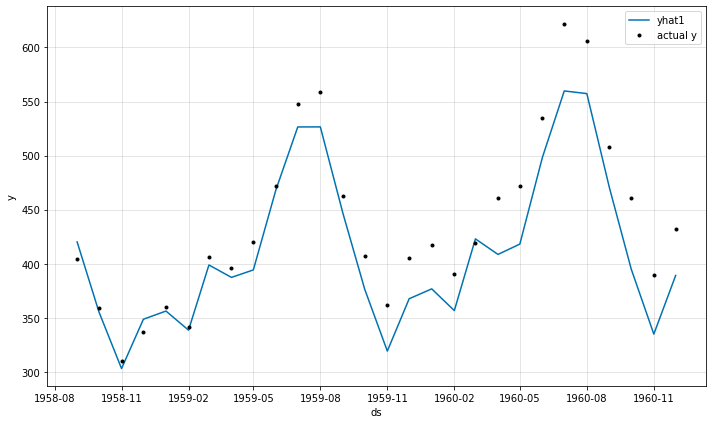

In [6]:
future = m.make_future_dataframe(df_train, periods=len(df_val))
forecast = m.predict(future)
forecast['y'] = df_val['y']
fig = m.plot(forecast)

## 1.2 CrossValidation

In [7]:
METRICS = ['SmoothL1Loss', 'MAE', 'MSE']
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

df = pd.read_csv(os.path.join('tmp-data', 'air_passengers.csv'))
folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="MS", k=5, fold_pct=0.1)

In [8]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_val = pd.DataFrame(columns=METRICS)

for df_train, df_val in folds:
    m = NeuralProphet(**params)
    train = m.fit(df=df_train, freq="MS")
    val = m.test(df=df_val)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_val = metrics_val.append(val[METRICS].iloc[-1])

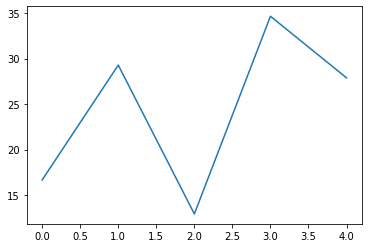

In [9]:
# metrics_train.reset_index(drop=True)
plt = metrics_val.reset_index(drop=True)["MAE"].plot()

In [10]:
metrics_val.describe().loc[["mean", "std", "min", "max"]]

,SmoothL1Loss,MAE,MSE
mean,0.004235,24.286545,800.390839
std,0.002487,9.106480,484.158126
min,0.001329,12.945528,268.740021
max,0.007858,34.644619,1500.670044


# 2 Single Experiments using Benchmark Framework

In [11]:
from neuralprophet.benchmark import Dataset, NeuralProphetModel, SimpleExperiment, CrossValidationExperiment
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark

## 2.1 SimpleExperiment
Let's set up a train test experiment:

In [12]:
ts = Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp = SimpleExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MAE", "MSE"],
    test_percentage=25,
)
result_train, result_val = exp.fit()

  0%|          | 0/203 [00:00<?, ?it/s]

In [15]:
# result_train
result_val

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MAE': 24.696687698364258,
 'MSE': 838.3250732421875}

## 2.2 CrossValidationExperiment
Let's crossvalidate:

In [16]:
ts = Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp_cv = CrossValidationExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MAE", "MSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
  )
result_train, result_val = exp_cv.fit()

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

In [17]:
result_val

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MAE': [16.595510482788086, 17.406164169311523, 30.80154800415039],
 'MSE': [434.49713134765625, 453.3460998535156, 1044.1944580078125]}

# 3 Running Multiple Experiments using Benchmark Framework

## 3.0 Configure Datasets and Model Parameters
First, we define the datasets that we would like to benchmerk on.
Next, we define the models that we want to evaluate and set their hyperparameters.

In [18]:
dataset_list = [
    Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS"),
    # Dataset(df = peyton_manning_df, name = "peyton_manning", freq = "D"),
    # Dataset(df = retail_sales_df, name = "retail_sales", freq = "D"),
    # Dataset(df = yosemite_temps_df, name = "yosemite_temps", freq = "5min"),
    # Dataset(df = ercot_load_df, name = "ercot_load", freq = "H"),
]
model_classes_and_params = [
    (NeuralProphetModel, {}),
    (NeuralProphetModel, {"n_changepoints": 5}),
    (NeuralProphetModel, {"seasonality_mode": "multiplicative", "learning_rate": 0.1}),
]

Note: As all the classes used in the Benchmark framework are dataclasses, 
they have a print function, allowing us to peek into them if we like:

In [19]:
model_classes_and_params

[(neuralprophet.benchmark.NeuralProphetModel, {}),
 (neuralprophet.benchmark.NeuralProphetModel, {'n_changepoints': 5}),
 (neuralprophet.benchmark.NeuralProphetModel,
  {'seasonality_mode': 'multiplicative', 'learning_rate': 0.1})]

## 3.1 SimpleBenchmark
Setting up a series of Train Test Experiments is quick:

In [21]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MAE", "MSE"],
    test_percentage=25,
)
results_train, results_val = benchmark.run()

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

In [22]:
results_val

,data,model,params,MAE,MSE
0,air_passengers,NeuralProphet,{},38.694496,1919.593994
1,air_passengers,NeuralProphet,{'n_changepoints': 5},39.901009,2001.652588
2,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",23.438099,768.311279


## 3.2 CrossValidationBenchmark
Setting up a series of crossvalidated experiments is just as simple:

In [23]:
benchmark_cv = CrossValidationBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MAE", "MSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
)
results_summary, results_train, results_val = benchmark_cv.run()

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

We now also get a summary DataFrame showing the metrics' mean and standard deviation over all folds.

In [24]:
results_summary

,data,model,params,train_MAE,train_MAE_std,train_MSE,train_MSE_std,val_MAE,val_MAE_std,val_MSE,val_MSE_std
0,air_passengers,NeuralProphet,{},12.009312,2.317369,269.175302,97.701901,31.720865,1.536947,1390.574544,32.777100
1,air_passengers,NeuralProphet,{'n_changepoints': 5},12.536254,2.216470,278.325587,96.449854,32.360241,1.645342,1508.976807,160.171228
2,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",5.974113,0.636990,61.190773,12.996045,19.436862,6.954656,527.340434,270.334174


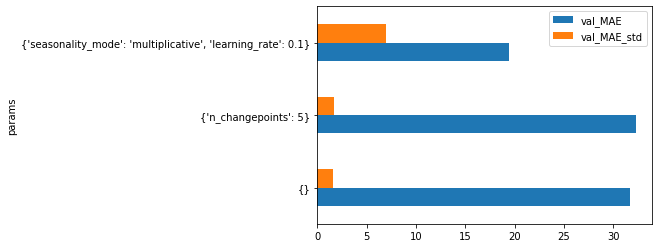

In [26]:
air_passengers = results_summary[results_summary['data'] == 'air_passengers']
plt = air_passengers.plot(x='params', y=['val_MAE', 'val_MAE_std'], kind='barh')

The metrics for each fold are also recoreded individually:

In [27]:
results_val

,data,model,params,MAE,MSE
0,air_passengers,NeuralProphet,{},"[33.67439651489258, 31.56938362121582, 29.9188...","[1356.4520263671875, 1380.465087890625, 1434.8..."
1,air_passengers,NeuralProphet,{'n_changepoints': 5},"[34.620487213134766, 30.75137710571289, 31.708...","[1423.0540771484375, 1370.4300537109375, 1733...."
2,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...","[16.69375991821289, 12.628718376159668, 28.988...","[434.4963684082031, 252.58364868164062, 894.94..."


In [28]:
# remove temporary data folder.
!rm -r tmp-data